# Airbnb data on Vienna

In [269]:
import gzip
import re
from pathlib import Path

import seaborn as sns
import tqdm
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Interesting questions:
- How did Covid-19 affect the availability of apartments in Vienna?
- How did Covid-19 affect the price of apartments in Vienna?
- Can we recognize whether a host is a superhost from their listing?

## Getting data

In [10]:
r = requests.get('http://insideairbnb.com/get-the-data.html')
bs = BeautifulSoup(r.content,'html.parser')

In [ ]:
for a_tag in bs.find('table', class_='vienna').find_all('a'):
    link = a_tag['href']
    date = re.findall('\d{4}-\d{2}-\d{2}',link)[0]
    file_name = link.split('/')[-1]
    if file_name[-2:]=='gz' and int(date[:4])>=2019:
        r = requests.get(link)
        file = gzip.decompress(r.content).decode()
        with open('data/'+date+'_'+file_name[:-3],'w') as f:
            f.write(file)

# Availability effects because of Covid-19
How did Covid-19 affect the availability of apartments in Vienna? Normally we expect the availability for a given day to go down as the day comes closer but with Covid-19, does it go up?
What data do we have? We use the calendar data from Inside Airbnb, where approximately once a month the availability, the price and adjusted price for the next 365 days for each listing are crawled.
We have snapshots from 22 February 2020 and 17 March 2020. Note that many measures to restrict Covid-19's spread in Austria were announced and came into effect in the first half of March (travel restrictions, curfew etc.), so we should see some effect in the data from March compared to February.

In [166]:
calendar_2002 = pd.read_csv('data/2020-02-22_calendar.csv')

In [167]:
calendar_2002.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,15883,2020-02-22,f,$87.00,$87.00,1,999
1,212649,2020-02-22,f,$45.00,$45.00,2,60
2,212649,2020-02-23,f,$45.00,$45.00,2,60
3,212649,2020-02-24,f,$45.00,$45.00,2,60
4,212649,2020-02-25,f,$45.00,$45.00,2,60


In [169]:
calendar_2002.info(null_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4804130 entries, 0 to 4804129
Data columns (total 7 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   listing_id      4804130 non-null  int64 
 1   date            4804130 non-null  object
 2   available       4804130 non-null  object
 3   price           4804130 non-null  object
 4   adjusted_price  4804130 non-null  object
 5   minimum_nights  4804130 non-null  int64 
 6   maximum_nights  4804130 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 256.6+ MB


So we need to convert date to a timestamp, availability to a boolean variable and convert price and adjusted_price to a float.

In [43]:
def preprocess_calendar(calendar):
    calendar['date'] = pd.to_datetime(calendar['date'])
    calendar['available'] = calendar['available'].str.replace("f","").astype(bool)
    calendar['price'] = calendar['price'].str.replace('$','').str.replace(',','').astype(float)
    calendar['adjusted_price'] = calendar['adjusted_price'].str.replace('$','').str.replace(',','').astype(float)
    return calendar

In [171]:
calendar_2002 = preprocess_calendar(calendar_2002)

Let's look at the average availability per night.

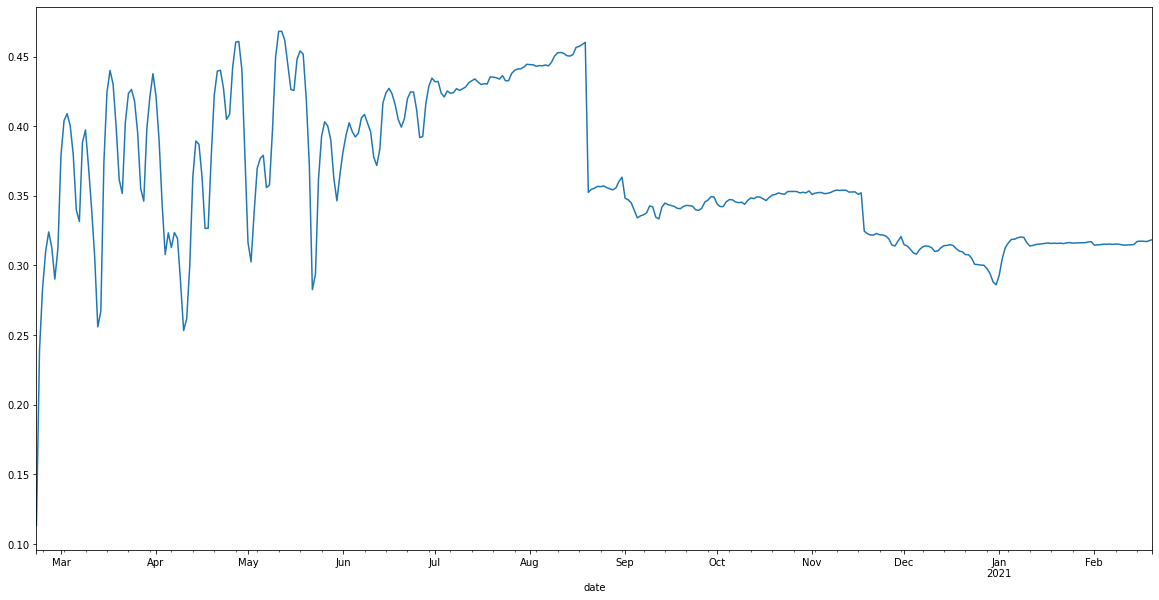

In [174]:
plt.figure(figsize=(20,10))
calendar_2002.groupby("date")['available'].mean().plot();

There seems to be a weekly pattern (business people being more likely to travel during the week, while people coming for leisure on and around weekends). We see that availability goes down on most weekends (as compared to during the weeks).
To see the long-term pattern, it might make sense to look at the rolling average (7 days) instead:

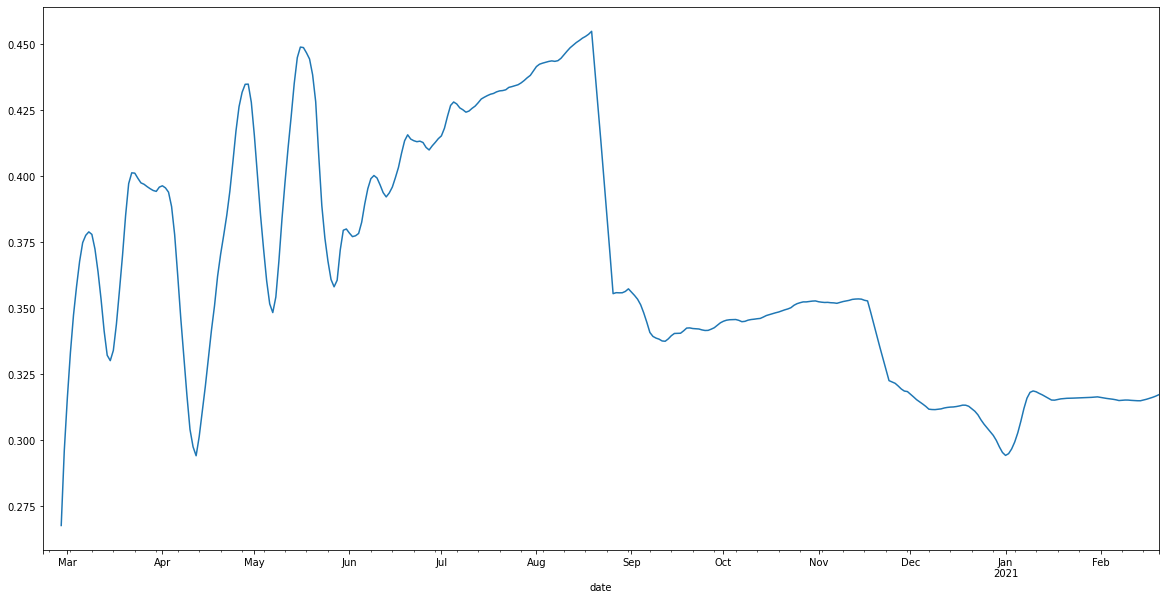

In [177]:
plt.figure(figsize=(20,10))
calendar_2002.groupby("date")['available'].mean().rolling(7).mean().plot();

We see that for the very near future (as of mid-february) availability is really low (around 20 %) and then goes up until mid-march where it has another low (for which I don't have an explanation). After that we have many bookings for Easter (12th April) and then for the holidays in May (1st of May, then ascension). Pentecoste and Corpus Christi seem still too far away yet to have a noticeable effect and availability steadily increases until a sharp decline at the end of August. Note that this date is pretty exactly half a year away from the day the calendar was updated, so most likely has nothing to do with the availability in Vienna but is due to the fact that hosts haven't updated their calendar yet for when their apartment is available. What is noticeable though and not an artifact most likely is another dip in availability at the beginning of 2021 which most likely is caused by people spending New Year's Eve or the days around that date in Vienna.

## How did the availability situation change because of Covid-19?

For that we are going to compare the booking calendars from February to that of March.

In [206]:
calendar_2002 = pd.read_csv('data/2020-02-22_calendar.csv')

In [207]:
calendar_2003 = pd.read_csv('data/2020-03-17_calendar.csv')

In [ ]:
calendar_2002 = preprocess_calendar(calendar_2002)
claendar_2003 = preprocess_calendar(calendar_2003)

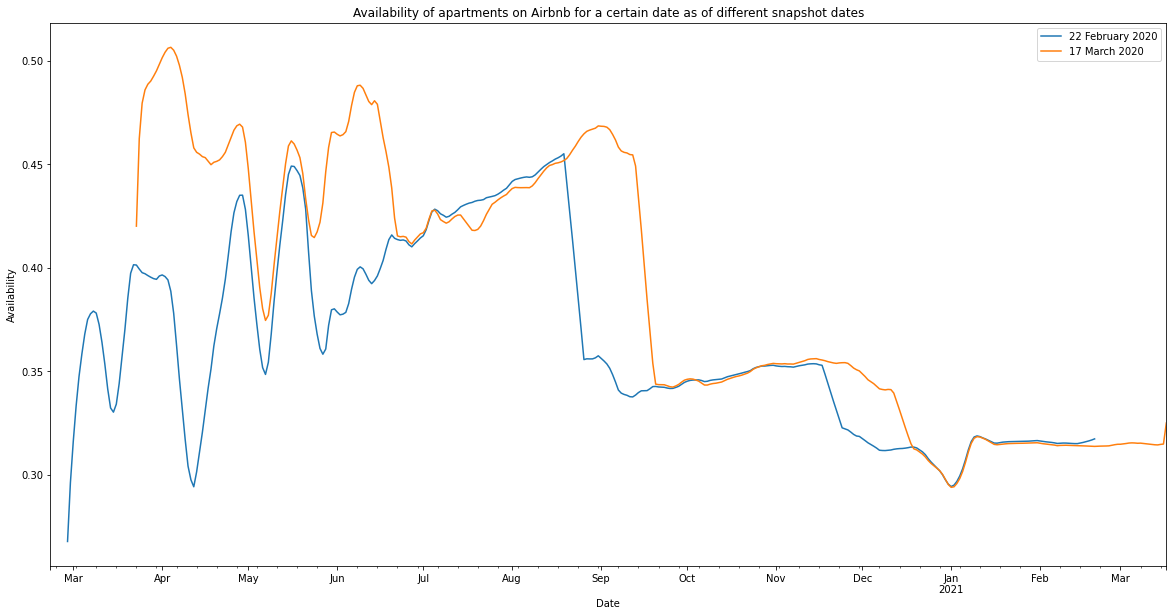

In [211]:
plt.figure(figsize=(20,10))
calendar_2002.groupby("date")['available'].mean().rolling(7).mean().plot(label = '22 February 2020')
calendar_2003.groupby("date")['available'].mean().rolling(7).mean().plot(label='17 March 2020')
plt.legend()
plt.ylabel('Availability')
plt.xlabel('Date')
plt.title('Availability of apartments on Airbnb for a certain date as of different snapshot dates');

We see that as of 17 March many more places were available via Airbnb than as of 22 February. For example for Easter (12 April), the avilability is around 15 % higher than it was in Mid-February. The discrepancies starting around the end of May do seem to have the same reason as the ones in September and in December: hosts not having up-to-date calendars (maybe because of strategy so availability seems higher than it is). We thus assume that the strong noticeable effect of mass cancellations ceases in May, but note that the availability in May as of mid-march is approximately the same as of Mid-February.

Compare to last year:

In [280]:
calendar_1902 = preprocess_calendar(pd.read_csv('data/2019-02-09_calendar.csv'))

In [281]:
calendar_1903 = preprocess_calendar(pd.read_csv('data/2019-03-11_calendar.csv'))

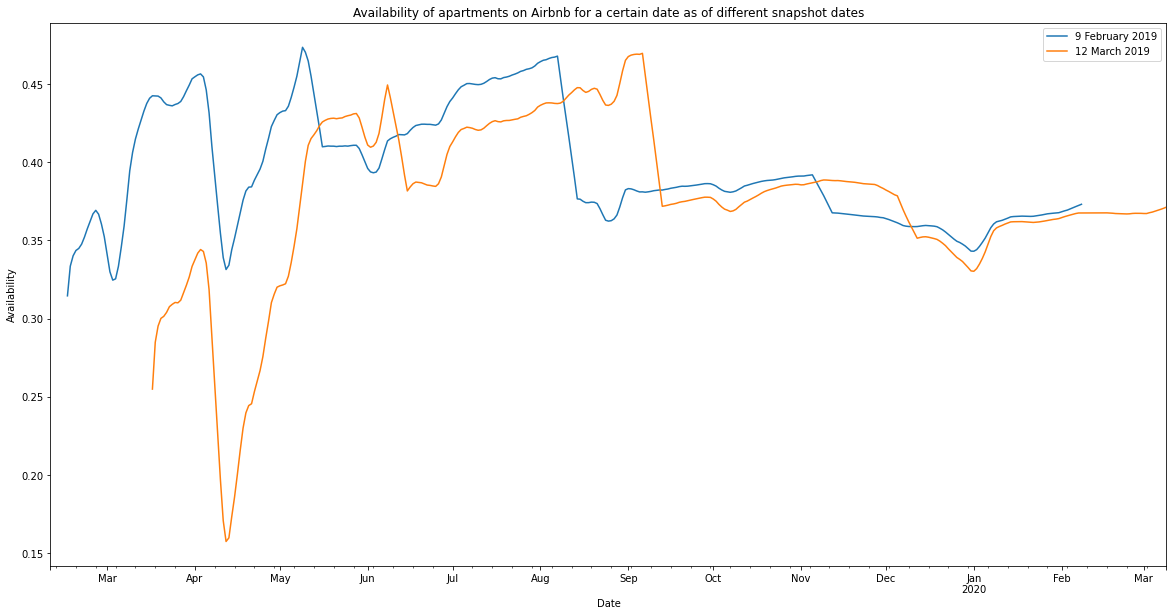

In [282]:
plt.figure(figsize=(20,10))
calendar_1902.groupby("date")['available'].mean().rolling(7).mean().plot(label='9 February 2019')
calendar_1903.groupby("date")['available'].mean().rolling(7).mean().plot(label='12 March 2019')
calendar_1902.groupby("date")['available'].mean().rolling(7).mean().plot(label='9 February 2019')
calendar_1903.groupby("date")['available'].mean().rolling(7).mean().plot(label='12 March 2019')
plt.legend()
plt.ylabel('Availability')
plt.xlabel('Date')
plt.title('Availability of apartments on Airbnb for a certain date as of different snapshot dates');

Compare above plot to the plot here, showing availability as of mid-February and mid-march 2019. We see that the availability for Easter as of March is only a little over 15 %, more than 15% below the availability as of February. After that date the availability starts rising but the February availability stays well below the March availability. The crossing of the lines in mid-may most likely is again caused by a data artifact, note that the steep decline in availability in the February data appears again in the March data one month later.

# Price changes because of Covid-19?

How did Covid-19 affect prices for accommodations? We assume the following:
- Price: base price for an apartment
- adjusted price: price you pay if you book on the snapshot date

We assume the pricing model follows a supply-demand model where higher availability means lower prices, where the demand might be predicted by some Airbnb model.

In [212]:
calendar_2003_short= calendar_2003[calendar_2003['date']<pd.to_datetime('2020-06-30')].copy()
calendar_2002_short = calendar_2002[calendar_2002['date']<pd.to_datetime('2020-06-30')].copy()

In [44]:
def join_calendars(calendar_1, calendar_2, suffix_1, suffix_2):
    """
    join two calendars on date and listing id
    """
    calendar_1['join_key'] = calendar_1.apply(lambda x: str(x['listing_id'])+str(x['date']), axis=1)
    calendar_2['join_key'] = calendar_2.apply(lambda x: str(x['listing_id'])+str(x['date']), axis=1)
    calendar_join = pd.merge(left=calendar_1, right=calendar_2[['join_key','available','adjusted_price']], on = 'join_key', suffixes=(suffix_1,suffix_2))
    calendar_join.drop(columns=['join_key'], inplace=True)
    return calendar_join

In [223]:
calendar_20_join = join_calendars(calendar_2002_short, calendar_2003_short, "_feb","_mar")

In [224]:
calendar_20_join

,listing_id,date,available_feb,price,adjusted_price_feb,minimum_nights,maximum_nights,available_mar,adjusted_price_mar
0,212649,2020-03-17,False,45.0,45.0,2,60,False,45.0
1,212649,2020-03-18,False,45.0,45.0,2,60,True,45.0
2,212649,2020-03-19,False,45.0,45.0,2,60,True,45.0
3,212649,2020-03-20,False,45.0,45.0,2,60,True,45.0
4,212649,2020-03-21,False,45.0,45.0,2,60,True,45.0
...,...,...,...,...,...,...,...,...,...
1333616,42456061,2020-06-25,True,65.0,65.0,1,1125,True,66.0
1333617,42456061,2020-06-26,True,65.0,65.0,1,1125,True,75.0
1333618,42456061,2020-06-27,True,65.0,65.0,1,1125,True,75.0
1333619,42456061,2020-06-28,True,65.0,65.0,1,1125,True,60.0


In [225]:
calendar_20_join[calendar_20_join['adjusted_price_feb']<calendar_20_join['adjusted_price_mar']].shape

(81496, 9)

In [226]:
calendar_20_join[calendar_20_join['adjusted_price_mar']<calendar_20_join['adjusted_price_feb']].shape

(238637, 9)

In [230]:
calendar_20_join.groupby(['available_feb','available_mar'])[['adjusted_price_feb','adjusted_price_mar']].mean()

adjusted_price_feb  adjusted_price_mar
available_feb available_mar                                        
False         False                   72.312869           75.304768
              True                    83.312231           81.012518
True          False                   88.435795          105.541358
              True                    99.488356           94.872347

In [ ]:
mask = calendar_20_join['available_feb'] & calendar_join['available_mar']
plt.figure(figsize=(20,10))
calendar_20_join[mask].groupby('date')['adjusted_price_feb'].median().rolling(7).mean().plot(label='22 February 2020', color='blue')
calendar_20_join[mask].groupby('date')['adjusted_price_mar'].median().rolling(7).mean().plot(label='17 March 2020', color='orange')
plt.legend()
plt.ylabel('Price [USD]')
plt.xlabel('Date')
plt.title('Rolling average (7 days) of median price for a given date on a given snapshot date (only for listings available on all snapshot dates)');

We see that for the second half of march the price in March lies almost 10 USD below the price from February. The difference gradually gets smaller until around the beginning of May the differences are negligible.

Compare this to the last year:

In [236]:
calendar_1903_short= calendar_1903[calendar_1903['date']<pd.to_datetime('2019-06-30')].copy()
calendar_1902_short = calendar_1902[calendar_1902['date']<pd.to_datetime('2019-06-30')].copy()

In [237]:
calendar_19_join = join_calendars(calendar_1902_short, calendar_1903_short, "_feb","_mar")

In [238]:
calendar_19_join

,listing_id,date,available_feb,price,adjusted_price_feb,minimum_nights,maximum_nights,available_mar,adjusted_price_mar
0,2309,2019-03-11,False,80.0,80.0,4,365,False,80.0
1,2309,2019-03-12,False,80.0,80.0,4,365,False,80.0
2,2309,2019-03-13,False,80.0,80.0,4,365,False,80.0
3,2309,2019-03-14,False,80.0,80.0,4,365,False,80.0
4,2309,2019-03-15,False,80.0,80.0,4,365,False,80.0
...,...,...,...,...,...,...,...,...,...
1175707,32241530,2019-06-25,True,49.0,49.0,1,1125,True,59.0
1175708,32241530,2019-06-26,True,49.0,49.0,1,1125,True,59.0
1175709,32241530,2019-06-27,True,49.0,49.0,1,1125,False,59.0
1175710,32241530,2019-06-28,True,49.0,49.0,1,1125,False,59.0


In [239]:
calendar_19_join.groupby(['available_feb','available_mar'])[['adjusted_price_feb','adjusted_price_mar']].mean()

adjusted_price_feb  adjusted_price_mar
available_feb available_mar                                        
False         False                   66.038010           65.745077
              True                    94.582877           75.657723
True          False                   77.621028           75.562306
              True                    99.278826           98.878268

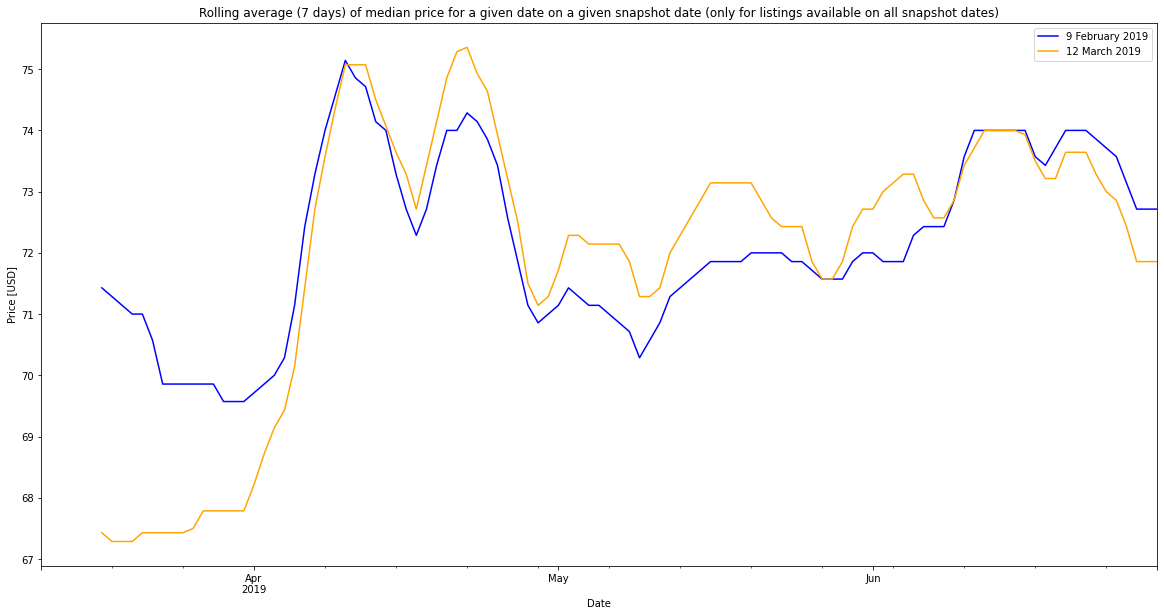

In [241]:
mask = calendar_19_join['available_feb'] & calendar_join['available_mar']
plt.figure(figsize=(20,10))
calendar_19_join[mask].groupby('date')['adjusted_price_feb'].median().rolling(7).mean().plot(label='9 February 2019', color='blue')
calendar_19_join[mask].groupby('date')['adjusted_price_mar'].median().rolling(7).mean().plot(label='12 March 2019', color='orange')
plt.legend()
plt.ylabel('Price [USD]')
plt.xlabel('Date')
plt.title('Rolling average (7 days) of median price for a given date on a given snapshot date (only for listings available on all snapshot dates)');

Note that while here the prices as of March for the near future are also lower as the ones from February, the difference is only around 4 USD and starting around the start of April becomes negligible. To ensure that the effect from Covid-19 is atypical, we look at the other pairs of two successive months and the differences their.

In [45]:
dates = ['2019-01-17','2019-02-09','2019-03-11','2019-04-14','2019-05-15','2019-06-11','2019-07-13','2019-08-14','2019-09-20','2019-10-18','2019-11-19','2019-12-15','2020-01-14','2020-02-22','2020-03-17']

In [48]:
difference_dct = {}
for i in tqdm.tqdm(list(range(len(dates)-1))):
    date_1 = dates[i]
    date_2 = dates[i+1]
    if i==0:
        calendar_1 = preprocess_calendar(pd.read_csv('data/'+date_1+'_calendar.csv'))
        calendar_1 = calendar_1[(calendar_1['date']< pd.to_datetime(date_2)+pd.to_timedelta(50,'days'))& (calendar_1['date']>= pd.to_datetime(date_2))]
    else:
        calendar_1 = calendar_2
    calendar_2 = preprocess_calendar(pd.read_csv('data/'+date_2+'_calendar.csv'))
    calendar_2 = calendar_2[calendar_2['date']< pd.to_datetime(date_2)+pd.to_timedelta(80,'days')]
    calendar_join = join_calendars(calendar_1, calendar_2, '_'+date_1, '_'+date_2)
    mask = calendar_join['available_'+date_1] & calendar_join['available_'+date_2]
    differences = calendar_join[mask].groupby('date')['adjusted_price_'+date_1].median().rolling(7).mean() - calendar_join[mask].groupby('date')['adjusted_price_'+date_2].median().rolling(7).mean()
    dct = {}
    for j in range(1,5):
        dct[str(j)+'_week'] = differences[pd.to_datetime(date_2)+pd.to_timedelta(7*j,'days')]
    difference_dct[date_1]= dct



  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [01:26<18:39, 86.09s/it]

 14%|█▍        | 2/14 [02:53<17:17, 86.43s/it]

 21%|██▏       | 3/14 [04:20<15:53, 86.67s/it]

 29%|██▊       | 4/14 [05:48<14:30, 87.04s/it]

 36%|███▌      | 5/14 [07:13<12:56, 86.31s/it]

 43%|████▎     | 6/14 [08:41<11:36, 87.08s/it]

 50%|█████     | 7/14 [10:13<10:19, 88.47s/it]

 57%|█████▋    | 8/14 [11:46<08:58, 89.67s/it]

 64%|██████▍   | 9/14 [13:15<07:28, 89.73s/it]

 71%|███████▏  | 10/14 [14:46<06:00, 90.02s/it]

 79%|███████▊  | 11/14 [16:18<04:31, 90.58s/it]

 86%|████████▌ | 12/14 [17:53<03:03, 91.83s/it]

 93%|█████████▎| 13/14 [19:29<01:33, 93.07s/it]

100%|██████████| 14/14 [21:04<00:00, 90.34s/it]


In [60]:
difference_df = pd.DataFrame(difference_dct).T

In [62]:
difference_df.index = pd.to_datetime(difference_df.index)

In [66]:
difference_df

,1_week,2_week,3_week,4_week
2019-01-17,4.000000,4.000000,3.714286,1.428571
2019-02-09,4.000000,2.428571,1.500000,0.428571
2019-03-11,1.071429,-0.285714,-1.500000,-0.571429
2019-04-14,4.928571,3.428571,1.500000,1.214286
2019-05-15,2.142857,1.000000,0.285714,0.714286
2019-06-11,5.142857,3.214286,3.714286,3.857143
2019-07-13,2.642857,2.428571,1.357143,0.857143
2019-08-14,4.928571,3.285714,2.928571,4.571429
2019-09-20,4.714286,2.428571,1.000000,1.000000
2019-10-18,4.428571,2.071429,1.285714,-1.071429


<Figure size 1440x720 with 0 Axes>

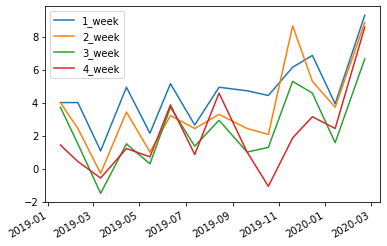

In [68]:
plt.figure(figsize=(20,10))
difference_df.plot();

So we see that the differences from February to March 2020 are all larger than ever before, some of them clearly. Note that from November to December the differences are also larger than usual, presumingly because the model predicting demand for Airbnb's in Vienna didn't predict well enough how many people want to book a place for Christmas and New Year's Eve (This would explain why the 4-week-difference (i.e., prices for four weeks after 15 December 2019, which falls into the first week after the Christmas holidays, is considerably smaller than the others). To further test this theory it would make sense to look at data from 2018 and preceding years.

# Predict superhost, what are important factors
For the last question, we want to determine whether somebody is a superhost or not from the listing. What are the important factors influencing whether somebody is a superhost?

In [113]:
listings = pd.read_csv("data/2020-03-17_listings.csv")

/home/martin/Data_Science_ND/blog/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (62) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [114]:
listings.shape

(13224, 106)

In [115]:
pd.options.display.max_columns = 107
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,15883,https://www.airbnb.com/rooms/15883,20200317180025,2020-03-17,b&b near Old Danube river,"Four rooms, each one differently and individua...","Old Danube river, a short walk to one of the s...","Four rooms, each one differently and individua...",none,"small and personal Four rooms at this B&B, eac...","Und sonst? Na ja, und sonst wird spätestens zu...",9 minutes to the city The nearest metro statio...,"free wifi, many books about Vienna, great tipp...",I live here! I am ready for questions any time...,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/18eff738-a...,NaN,62142,https://www.airbnb.com/users/show/62142,Eva,2009-12-11,"Vienna, Wien, Austria",Mein größtes Hobby: Reisen! Am liebsten mit me...,within an hour,100%,93%,f,https://a0.muscache.com/im/pictures/user/24166...,https://a0.muscache.com/im/pictures/user/24166...,Donaustadt,6.0,6.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Vienna, Vienna, Austria",Donaustadt,Donaustadt,NaN,Vienna,Vienna,1220,Vienna,"Vienna, Austria",AT,Austria,48.24262,16.42767,t,Bed and breakfast,Hotel room,3,1.0,1.0,2.0,Real Bed,"{TV,Wifi,""Air conditioning"",Breakfast,""Free st...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$10.00,1,365,1,1,999,999,1.0,999.0,5 days ago,t,26,46,66,314,2020-03-17,11,2,2015-04-10,2020-02-19,95.0,10.0,10.0,10.0,10.0,9.0,9.0,f,NaN,NaN,t,f,moderate,f,f,6,4,0,0,0.18
1,38768,https://www.airbnb.com/rooms/38768,20200317180025,2020-03-17,central cityapartement- wifi- nice neighbourhood,39m² apartment with beautiful courtyard of the...,"Holiday atmosphere apartment, 39m². 2 rooms w...",39m² apartment with beautiful courtyard of the...,none,the Karmeliterviertel became very popular in t...,The great neighborhood and central location of...,300 meters from subway U2 Taborstraße and Tram...,Fresh towels and bedding will be provided. Fre...,I will meet the guests at their arriving to ha...,Die Gäste werden gebeten die Wohnung in einem ...,NaN,NaN,https://a0.muscache.com/im/pictures/7a2b25f8-a...,NaN,166283,https://www.airbnb.com/users/show/166283,Hannes,2010-07-14,"Vienna, Wien, Austria",I am open minded and like travelling myself. I...,within an hour,100%,100%,f,https://a0.muscache.com/im/users/166283/profil...,https://a0.muscache.com/im/users/166283/profil...,Leopoldstad

look at null counts:

## Preprocess data

In [116]:
listings.info(null_counts=True,verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13224 entries, 0 to 13223
Data columns (total 106 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            13224 non-null  int64  
 1   listing_url                                   13224 non-null  object 
 2   scrape_id                                     13224 non-null  int64  
 3   last_scraped                                  13224 non-null  object 
 4   name                                          13210 non-null  object 
 5   summary                                       12601 non-null  object 
 6   space                                         9277 non-null   object 
 7   description                                   12917 non-null  object 
 8   experiences_offered                           13224 non-null  object 
 9   neighborhood_overview                         8242 non-null 

We want to include factors like host_response_rate, host_response_time or review_scores in our analysis and feel that a few 1000 samples is enough to detect a pattern, so drop rows where those are empty.

In [122]:
listings.dropna(subset=['host_response_time','host_response_rate','host_acceptance_rate','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
                        'review_scores_communication','review_scores_location','review_scores_value'], inplace=True)

To prevent data leakage (for example via host_acceptance_rate or calculated_host_listings_count), only keep one column per host.

In [123]:
listings.drop_duplicates(subset=['host_id'],inplace=True)

In [124]:
listings.shape

(4415, 106)

So we have lots of columns with different issues. Leaving out the natural text columns the biggest work remains to be done on the columns amenities and host_verifications which contain lists of features. We are going to split those up in boolean columns for each feature appearing in any sample. The boolean columns are encoded as 't','f', we are going to encode the categorical columns and the time columns correctly. Also the columns containing the price or host_response_rate, host_acceptance_rate need to be converted to numeric. There are some columns which contain redundant or vacuous information which we are going to remove. For sake of simplicity we also leave out the columns containing text from our analysis.

In [125]:
col = 'amenities'

In [126]:
# split up different values in amenities column
options = list(set(([x for y in listings[col].str.strip('{}').str.split(',') for x in y])))

In [127]:
# we split up at commas, multi-word values are enclosed by quotes; can detect missplits by counting quotes
[x for x in list(set(([x for y in listings[col].str.strip('{}').str.split(',') for x in y]))) if x.count('"')%2==1]

[' toilet"', '"Wide clearance to shower']

In [128]:
for option in ['"Wide clearance to shower',' toilet"', '']:
    if option in options:
        options.remove(option)
option = '"Wide clearance to shower, toilet"'
if option not in options:
    options.append('"Wide clearance to shower, toilet"')

for option in options:
    listings[col+'_'+option] = listings[col].apply(lambda x: option in x)

In [129]:
# analogously for host_verifications column, note that information there is encoded a little differently than in the amenities column
col = 'host_verifications'

options = np.unique([x for y in listings[col].str.strip('[]').str.split(',') for x in y])
options = [x.strip("', ") for x in options]
if '' in options:
    options.remove('')
if 'None' in options:
    options.remove('None')
option = options[0]
for option in options:
    listings[col+'_'+option] = listings[col].apply(lambda x: "'"+option+"'" in x)

In [130]:
# date columns
for col in ['host_since','first_review','last_review']:
    listings[col] = (pd.to_datetime(listings[col])-pd.to_datetime('1970-01-01')).dt.total_seconds()
# categorical columns
for col in ['host_response_time','property_type','room_type','bed_type','cancellation_policy','zipcode']:
    listings[col] = listings[col].astype('category')
# Boolean columns
for col in ['host_is_superhost','host_has_profile_pic','host_identity_verified','is_location_exact','requires_license','instant_bookable','is_business_travel_ready',
           'require_guest_profile_picture','require_guest_phone_verification','has_availability']:
    listings[col] = listings[col].str.replace('f','').astype(bool)
# numeric columns
for col in ['price', 'security_deposit','cleaning_fee','extra_people']:
    listings[col] = listings[col].str.replace('$','').str.replace(',','').astype(float)
for col in ['host_acceptance_rate','host_response_rate']:
    listings[col] = listings[col].str.replace('%','').astype(float)

In [131]:
columns_to_keep = ['host_since','host_response_time','host_response_rate','host_acceptance_rate','host_listings_count','host_total_listings_count','host_is_superhost',
                 'host_has_profile_pic','host_identity_verified','zipcode','latitude','longitude','is_location_exact','property_type','room_type','accommodates',
                 'bathrooms','bedrooms','beds','bed_type','guests_included','has_availability','availability_30','availability_60','availability_90','availability_365',
                 'number_of_reviews','number_of_reviews_ltm','first_review','last_review','review_scores_rating','review_scores_accuracy', 'review_scores_cleanliness',
                  'review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','requires_license','instant_bookable',
                  'is_business_travel_ready','cancellation_policy','require_guest_profile_picture','require_guest_phone_verification','calculated_host_listings_count',
                  'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms',
                  'reviews_per_month','price']

In [132]:
categorical_columns = ['host_response_time','zipcode','property_type','room_type','bed_type','cancellation_policy']

In [133]:
columns_to_keep.extend([column for column in listings.columns if column.startswith('amenities_')])
columns_to_keep.extend([column for column in listings.columns if column.startswith('host_verifications_')])

In [240]:
# df for modeling
listings_model = listings[columns_to_keep].copy()

In [241]:
listings_model.info(null_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4415 entries, 0 to 13180
Data columns (total 235 columns):
 #   Column                                                  Non-Null Count  Dtype   
---  ------                                                  --------------  -----   
 0   host_since                                              4415 non-null   float64 
 1   host_response_time                                      4415 non-null   category
 2   host_response_rate                                      4415 non-null   float64 
 3   host_acceptance_rate                                    4415 non-null   float64 
 4   host_listings_count                                     4415 non-null   float64 
 5   host_total_listings_count                               4415 non-null   float64 
 6   host_is_superhost                                       4415 non-null   bool    
 7   host_has_profile_pic                                    4415 non-null   bool    
 8   host_identity_verified    

Use mean imputation for na values, only very few cases.

In [242]:
listings_model = pd.get_dummies(listings_model, columns = categorical_columns,)

# Prepare for modelling

Split in features and target and keep 20 % for evaluation. Impute with mean using the SimpleImputer from sklearn.

In [243]:
X = listings_model.drop(columns='host_is_superhost')
y = listings_model['host_is_superhost']

In [244]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [245]:
si = SimpleImputer(missing_values=np.nan)

In [246]:
X_train = si.fit_transform(X_train)

## Modelling

We use decision trees and random forests, both default but also with crossvalidation. Since the classes are almost balanced, the difference between accuracy and balanced accuracy shouldn't be too big.

### Decision Tree

In [247]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [248]:
def print_metrics(model):
    """
    print a few scores for the input model evaluated on the test set
    """
    y_pred = model.predict(si.transform(X_test))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred))
    print("Confusion matrix:")
    plot_confusion_matrix(model, si.transform(X_test), y_test)

Accuracy: 0.7859569648924122
Balanced accuracy: 0.7810460742341743
Confusion matrix:


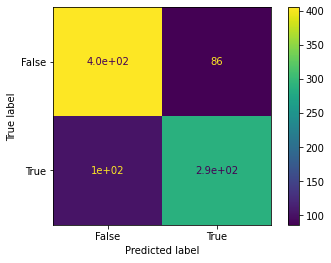

In [249]:
print_metrics(dt)

### Decision tree with hyperparameter search and cross-validation

In [250]:
parameters = {
    'max_depth':[5,10,20,50,None],
    'min_samples_split':[2,5,10,20,50]
}

In [251]:
dt_clf = GridSearchCV(dt, parameters, verbose=10, cv=5)
dt_clf.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] max_depth=5, min_samples_split=2 ................................
[CV] .... max_depth=5, min_samples_split=2, score=0.844, total=   0.1s
[CV] max_depth=5, min_samples_split=2 ................................
[CV] .... max_depth=5, min_samples_split=2, score=0.844, total=   0.1s
[CV] max_depth=5, min_samples_split=2 ................................
[CV] .... max_depth=5, min_samples_split=2, score=0.841, total=   0.1s
[CV] max_depth=5, min_samples_split=2 ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s


[CV] .... max_depth=5, min_samples_split=2, score=0.819, total=   0.1s
[CV] max_depth=5, min_samples_split=2 ................................
[CV] .... max_depth=5, min_samples_split=2, score=0.830, total=   0.1s
[CV] max_depth=5, min_samples_split=5 ................................
[CV] .... max_depth=5, min_samples_split=5, score=0.844, total=   0.0s
[CV] max_depth=5, min_samples_split=5 ................................
[CV] .... max_depth=5, min_samples_split=5, score=0.846, total=   0.1s
[CV] max_depth=5, min_samples_split=5 ................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.4s remaining:    0.0s


[CV] .... max_depth=5, min_samples_split=5, score=0.841, total=   0.1s
[CV] max_depth=5, min_samples_split=5 ................................
[CV] .... max_depth=5, min_samples_split=5, score=0.817, total=   0.1s
[CV] max_depth=5, min_samples_split=5 ................................
[CV] .... max_depth=5, min_samples_split=5, score=0.827, total=   0.1s
[CV] max_depth=5, min_samples_split=10 ...............................
[CV] ... max_depth=5, min_samples_split=10, score=0.844, total=   0.1s
[CV] max_depth=5, min_samples_split=10 ...............................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.5s remaining:    0.0s


[CV] ... max_depth=5, min_samples_split=10, score=0.846, total=   0.1s
[CV] max_depth=5, min_samples_split=10 ...............................
[CV] ... max_depth=5, min_samples_split=10, score=0.841, total=   0.1s
[CV] max_depth=5, min_samples_split=10 ...............................
[CV] ... max_depth=5, min_samples_split=10, score=0.817, total=   0.1s
[CV] max_depth=5, min_samples_split=10 ...............................
[CV] ... max_depth=5, min_samples_split=10, score=0.829, total=   0.1s
[CV] max_depth=5, min_samples_split=20 ...............................
[CV] ... max_depth=5, min_samples_split=20, score=0.844, total=   0.1s
[CV] max_depth=5, min_samples_split=20 ...............................
[CV] ... max_depth=5, min_samples_split=20, score=0.846, total=   0.1s
[CV] max_depth=5, min_samples_split=20 ...............................
[CV] ... max_depth=5, min_samples_split=20, score=0.841, total=   0.1s
[CV] max_depth=5, min_samples_split=20 ...............................
[CV] .

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:   11.7s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [5, 10, 20, 50, None],
                 

Accuracy: 0.840317100792752
Balanced accuracy: 0.8335264350139241
Confusion matrix:


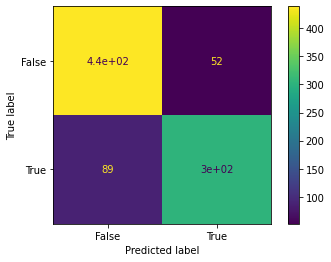

In [252]:
print_metrics(dt_clf)

### Random Forest

In [253]:
rf = RandomForestClassifier()

In [254]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Accuracy: 0.8380520951302378
Balanced accuracy: 0.8314897751361237
Confusion matrix:


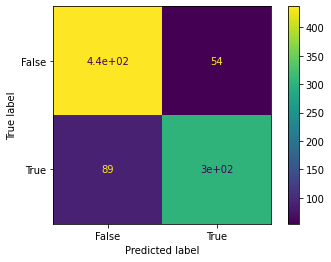

In [255]:
print_metrics(rf)

### Random Forest with hyperparameter search

In [256]:
parameters = {
    'max_depth':[5,10,20,50,None],
    'min_samples_split':[2,5,10,20,50],
    'n_estimators': [10,50,100]
}

In [257]:
reg_rf = GridSearchCV(RandomForestClassifier(random_state=234), parameters, verbose=10, n_jobs=-1, cv=5)

In [258]:
reg_rf.fit(X_train, y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=234,
                                 

Accuracy: 0.8459796149490374
Balanced accuracy: 0.8411898873602395
Confusion matrix:


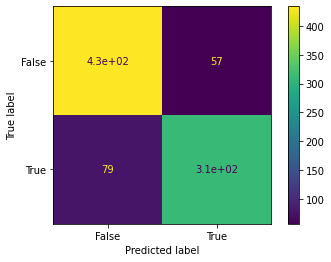

In [259]:
print_metrics(reg_rf)

## Use model attributes

Since they are easier to understand and are in this case equally good, use the decision tree we got via cross validation. Check for overfitting:

In [260]:
accuracy_score(y_train, dt_clf.predict(X_train))

0.8564552661381654

Seems like there is not much overfitting present.

In [261]:
feature_importances = pd.DataFrame(zip(X.columns, dt_clf.best_estimator_.feature_importances_), columns = ['feature','importance'])

In [262]:
feature_importances.sort_values('importance',ascending=False).head(15)

,feature,importance
21,number_of_reviews_ltm,0.420248
24,review_scores_rating,0.389669
22,first_review,0.069699
20,number_of_reviews,0.054623
2,host_acceptance_rate,0.019968
4,host_total_listings_count,0.019568
23,last_review,0.004508
0,host_since,0.003582
40,reviews_per_month,0.003351
3,host_listings_count,0.003333


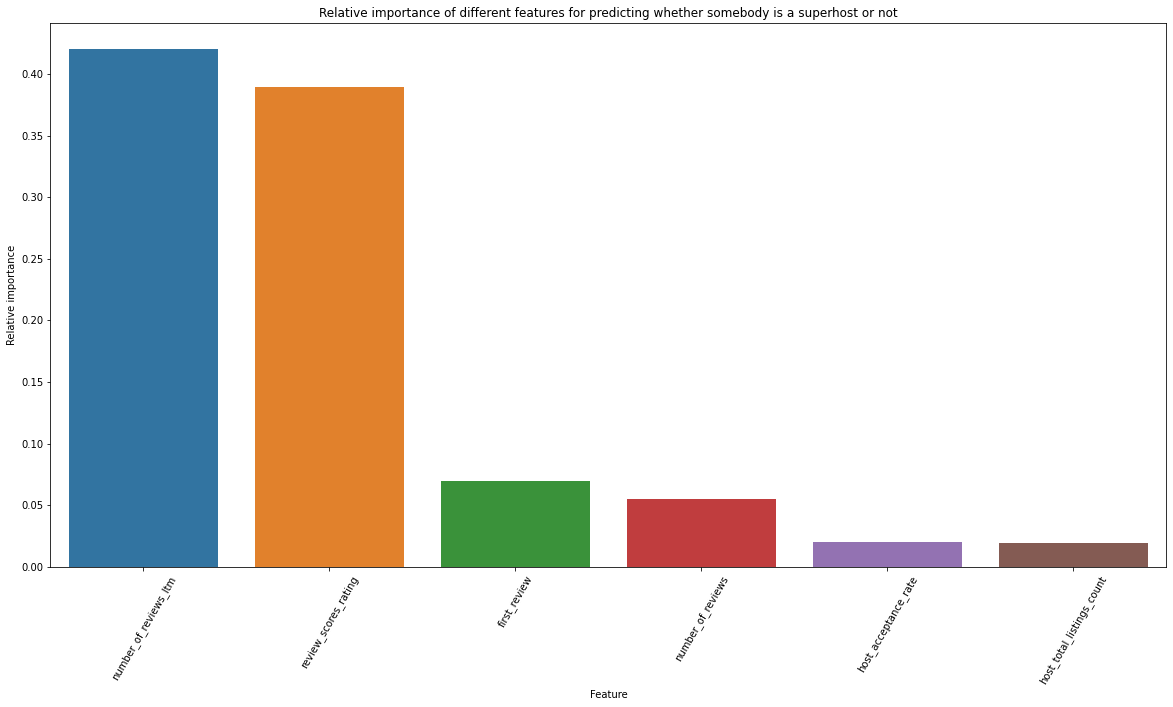

In [278]:
plt.figure(figsize=(20,10))
sns.barplot(x='feature',y='importance',data=feature_importances[feature_importances['importance']>0.01].sort_values('importance',ascending=False))
plt.xticks(rotation=60)
plt.ylabel("Relative importance")
plt.xlabel('Feature')
plt.title('Relative importance of different features for predicting whether somebody is a superhost or not');

So it seems that the number the rating and the number of reviews and the date of the first reviews and the rates with which the host accepts and the responds are the most important factors. Of course there is a strong correlation between these and other features such as host_since and others. To clearer isolate the factors influencing whether somebody is a superhost or not, 

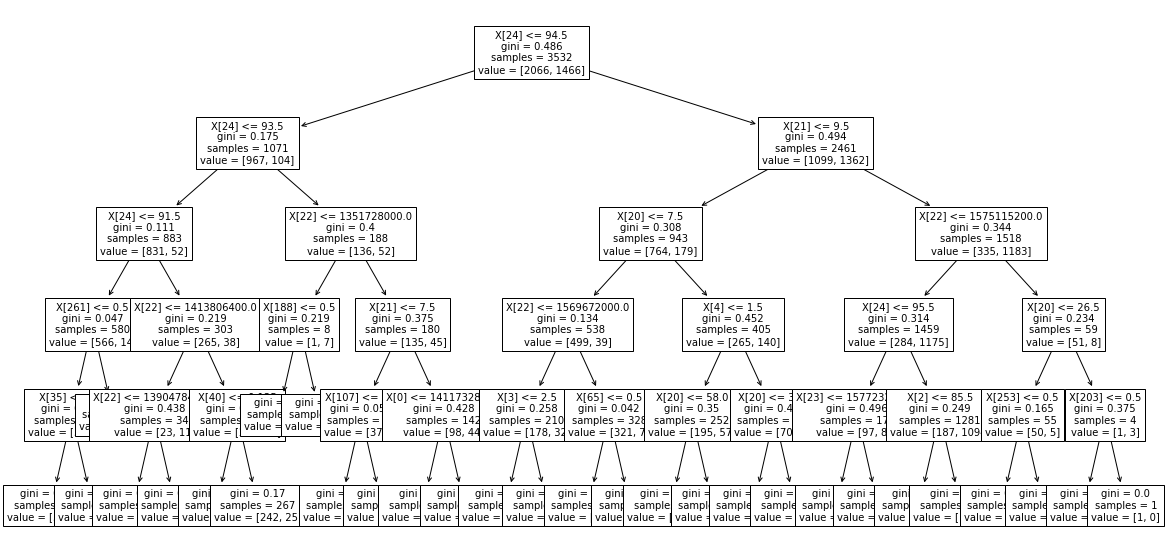

In [264]:
plt.figure(figsize=(20,10))
plot_tree(dt_clf.best_estimator_,fontsize=10);